In [5]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from skimage.io import imread

In [12]:
from skimage.feature import peak_local_max

def my_hough_line(img):
  thetas = np.deg2rad(np.arange(-90.0, 90.0))
  width, height = img.shape
  diag_len = np.ceil(np.sqrt(width * width + height * height))
  distances = np.arange(-diag_len, diag_len) 
  num_thetas = len(thetas)
  diag_len= int(diag_len)
  hspace = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
  y_i, x_i = np.nonzero(img) 

  for i in range(len(x_i)):
    for t_i in range(num_thetas):
      cos_t = np.cos(thetas[t_i])
      sin_t = np.sin(thetas[t_i])
      rho = round(x_i[i] * cos_t + y_i[i] * sin_t) + diag_len
      hspace[rho, t_i] += 1

  return hspace, thetas, distances

def my_hough_line_peaks(hough, angles, dis, k):
  lmc = peak_local_max(hough, min_distance=k)
  angele_ind = np.array([angles[lmc[0][1]], angles[lmc[1][1]]])
  dis_ind = np.array([dis[lmc[0][0]], dis[lmc[1][0]]])
  return angele_ind, dis_ind



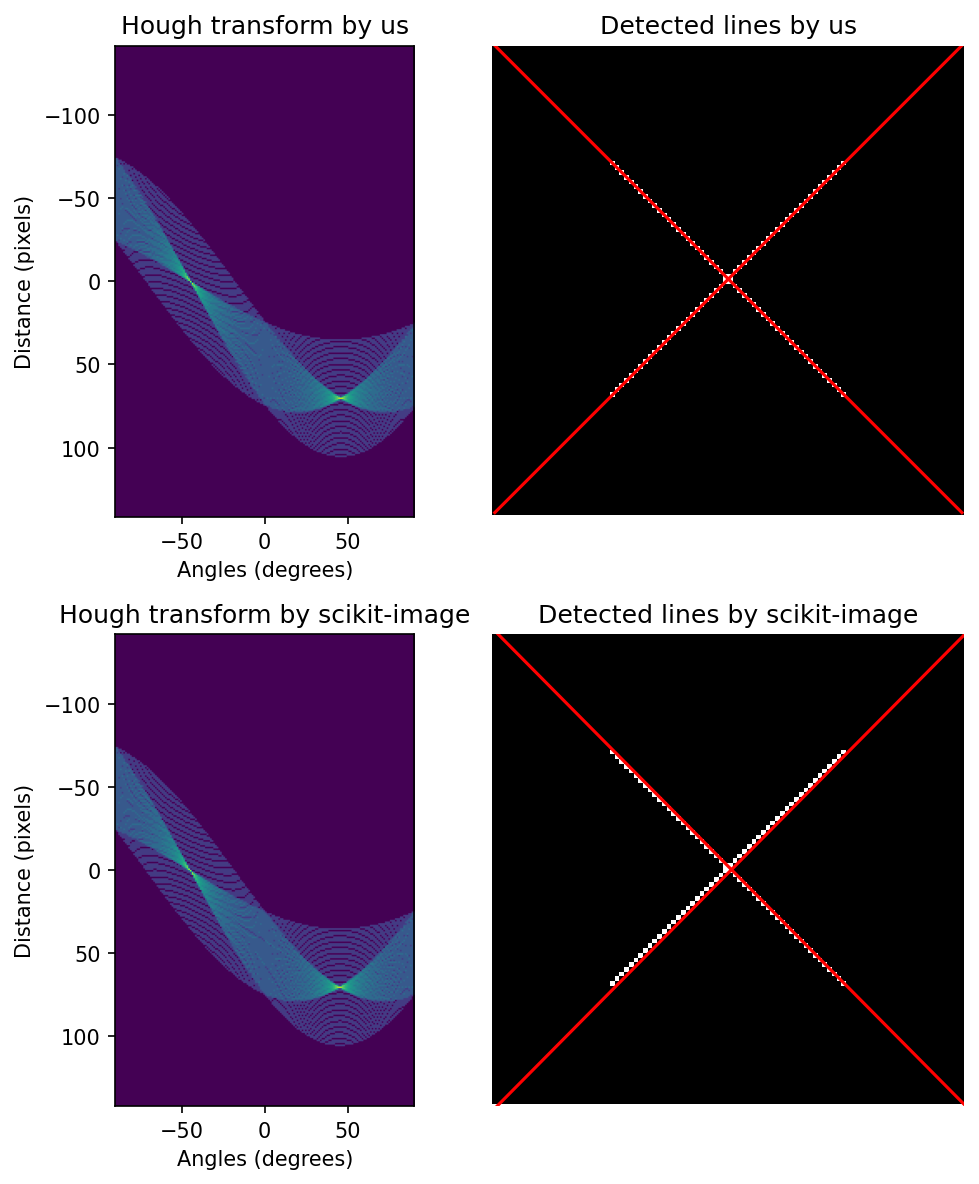

In [28]:
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny


def test1_2():
    image = imread('cross.png', as_gray=True)

    h, theta, d = my_hough_line(image)
    angle_cross, dis_cross = my_hough_line_peaks(h, theta, d, k = 30)
    x = np.arange(0, 100, 1)
    y0 = (dis_cross[0] - x*np.cos(angle_cross[0]))/np.sin(angle_cross[0])
    y1 = (dis_cross[1] - x*np.cos(angle_cross[1]))/np.sin(angle_cross[1])
    
    h_ref, theta_ref, d_ref = hough_line(image)
    _, angle_ref, dist_ref = hough_line_peaks(h_ref, theta_ref, d_ref)
    x0_ref, y0_ref= dist_ref[0] * np.array([np.cos(angle_ref[0]), np.sin(angle_ref[0])])
    x1_ref, y1_ref= dist_ref[1] * np.array([np.cos(angle_ref[1]), np.sin(angle_ref[1])])


    fig, axes = plt.subplots(2, 2, figsize=(7, 8), dpi=150)
    ax = axes.ravel()

    ax[0].imshow(np.log(1 + h), extent=[-90,90,142,-142])
    ax[0].set_title('Hough transform by us')
    ax[0].set_xlabel('Angles (degrees)')
    ax[0].set_ylabel('Distance (pixels)')
    ax[0].axis('image')

    ax[1].imshow(image, cmap='gray')
    ax[1].set_ylim((image.shape[0], 0))
    ax[1].set_axis_off()
    ax[1].set_title('Detected lines by us')
    ax[1].plot(x, y0, '-r')
    ax[1].plot(x, y1, '-r')

    ax[2].imshow(np.log(1 + h_ref), extent=[-90,90,142,-142])
    ax[2].set_title('Hough transform by scikit-image')
    ax[2].set_xlabel('Angles (degrees)')
    ax[2].set_ylabel('Distance (pixels)')
    ax[2].axis('image')

    ax[3].imshow(image, cmap='gray')
    ax[3].set_ylim((image.shape[0], 0))
    ax[3].set_axis_off()
    ax[3].set_title('Detected lines by scikit-image')
    ax[3].axline((x0_ref, y0_ref), slope=np.tan(angle_ref[0] + np.pi/2),color="red")
    ax[3].axline((x1_ref, y1_ref), slope=np.tan(angle_ref[1] + np.pi/2),color="red")

    plt.tight_layout()
    plt.savefig('1.2.png',bbox_inches='tight')
    plt.show()

test1_2()

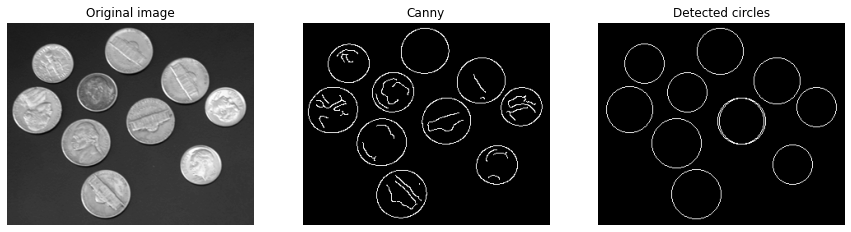

In [34]:
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter

def test1_3():
    image_coins = imread('coins.png')
    image_canny = canny(image_coins, sigma=2)

    radius = np.arange(20, 50, 2)
    res = hough_circle(image_canny, radius)
    threshold1=0.8 * np.max(res)

    accums, cx, cy, radii = hough_circle_peaks(res, radius,threshold=threshold1, total_num_peaks=11)
    image_edge_detection = image_canny.copy()
    image_edge_detection[image_edge_detection == True] = False
    for center_y, center_x, radius in zip(cy, cx, radii):
        circy, circx = circle_perimeter(center_y, center_x, radius,
                                        shape=image_edge_detection.shape)
        image_edge_detection[circy, circx] = True


    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    ax = axes.ravel()

    ax[0].imshow(image_coins, cmap='gray')
    ax[0].set_title('Original image')
    ax[0].set_axis_off()

    ax[1].imshow(image_canny, cmap='gray')
    ax[1].set_title('Canny')
    ax[1].set_axis_off()


    ax[2].imshow(image_edge_detection, cmap='gray')
    ax[2].set_axis_off()
    ax[2].set_title('Detected circles')

    plt.savefig('1.3.png',bbox_inches='tight')
    plt.show()

test1_3()

In [36]:
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, InputLayer
from tensorflow.keras.optimizers import Adam

## Configure the network
def test2():
    # batch_size to train
    batch_size = 20 * 256
    # number of output classes
    nb_classes = 135
    # number of epochs to train
    nb_epoch = 400

    # number of convolutional filters to use
    nb_filters = 20
    # size of pooling area for max pooling
    nb_pool = 2
    # convolution kernel size
    nb_conv = 5

    model = Sequential([
        InputLayer(input_shape=(29, 29, 1)),
        Conv2D(filters=nb_filters, kernel_size=nb_conv, activation='relu'),
        MaxPool2D(pool_size=(nb_pool, nb_pool)),
        Dropout(0.5),
        Conv2D(filters=nb_filters, kernel_size=nb_conv, activation='relu'),
        MaxPool2D(pool_size=(nb_pool, nb_pool)),
        Dropout(0.25),
        Flatten(),
        Dense(units=4000, activation='relu'),
        Dense(units=nb_classes, activation='softmax'),
    ])
        
    optimizer = Adam(lr=1e-4, epsilon=1e-08)

    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])


    # # Train model - uncoment to perform the training yourself


    # train = np.load('train.npz')
    # x_train = train['x_train'].reshape((-1, 29, 29, 1))
    # y_train = train['y_train']

    # early_stopping = EarlyStopping(patience=10)
    # history = model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size,
    #                    callbacks=[early_stopping], validation_split=0.2)
    # model.save_weights('keras1.h5')

    ## Load the pretrained network
    model.load_weights('keras.h5') 
    return model
model = test2()

C:\Users\cbcb9\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [37]:
def test2_2():
    test = np.load('test.npz')
    x_test = test['x_test']
    y_test = test['y_test']
    # print(x_test.shape)
    x_test = tf.squeeze(x_test)
    # print(x_test.shape)
    x_test = tf.expand_dims(x_test, axis=3)
    # print(x_test.shape)
    result = model.evaluate(x_test, y_test)
    print(result)
test2_2()

1317/1317 [==============================] - 9s 4ms/step - loss: 0.1166 - accuracy: 0.9577
[0.11661099642515182, 0.9576659202575684]


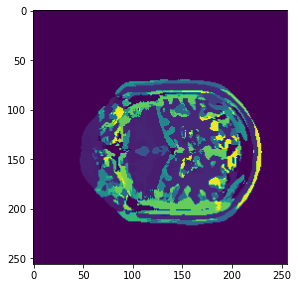

In [38]:
def patch_image(image):
    x,y = image.shape
    image = np.pad(image, ((14,14),(14,14)), constant_values=(0,0))
    patch = np.zeros((x*y,29,29))
    for i in range(x):
        for j in range(y):
            patch[i*256+j,:,:] = image[i:29+i,j:29+j]
    patch = patch / 255
    return patch

def test2_3():
    image = imread('test_images/image/1003_3_image.png')
    image_real = imread('test_images/seg/1003_3_seg.png')

    patch = patch_image(image)
    patch = tf.expand_dims(patch, axis=3)
    patch_result = model.predict(patch) 
    patch_result = np.argmax(patch_result,axis=1)
    segmented_image = patch_result.reshape(256,256)

    plt.figure(figsize = (10, 5))
    plt.subplot(1,2,1) 
    plt.imshow(segmented_image)
    # plt.subplot(1,2,2) 
    # plt.imshow(image_real)
    return image, segmented_image,image_real

image, segmented_image,image_real = test2_3()

In [39]:
def _dice(pred, true, k = 1):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

def mean_dice(pred, true, multi_class = 135):
    total_loss = 0
    class_count = 0
    for i in range(multi_class):
        if true[true == i].sum() != 0:
            class_count += 1
            pred_k = np.zeros((pred.shape))
            pred_k[pred == i] = 1

            true_k = np.zeros((pred.shape))
            true_k[true==i] = 1 
            total_loss += _dice(pred_k, true_k)
    print(total_loss/class_count)
    return total_loss / class_count

0.24071792397366862
0.24071792397366862


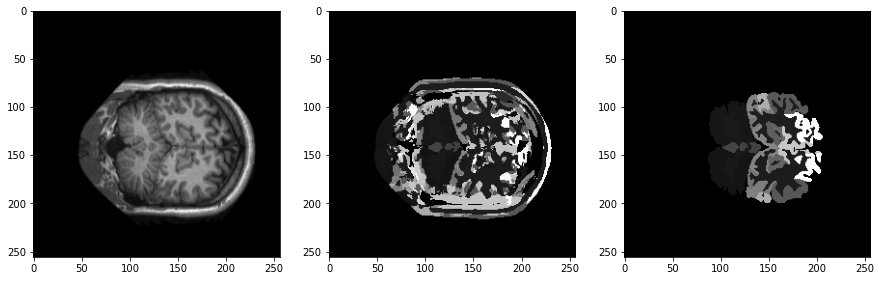

In [40]:
# def dice(im1, im2):
#     intersection =  im1==im2
#     result = 2. * intersection.sum() / (im1.size + im2.size)
#     return result
    
def test2_4():
    dice_coeffect = mean_dice(segmented_image,image_real)
    plt.figure(figsize = (15, 5))
    plt.subplot(1,3,1) 
    plt.imshow(image, cmap='gray')
    plt.subplot(1,3,2) 
    plt.imshow(segmented_image, cmap='gray')
    plt.subplot(1,3,3) 
    plt.imshow(image_real, cmap='gray')
    print(dice_coeffect)

test2_4()

(65536,)


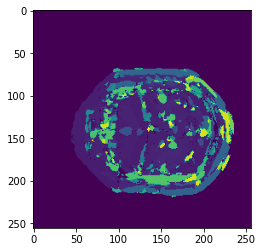

In [36]:
# def test2_5():
# batch_size to train
batch_size = 20 * 256
# number of output classes
nb_classes = 135
# number of epochs to train
nb_epoch = 400

# number of convolutional filters to use
nb_filters = 20
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 5

model = Sequential([
    InputLayer(input_shape=(29, 29, 1)),
    Conv2D(filters=nb_filters, kernel_size=nb_conv, activation='relu'),
    MaxPool2D(pool_size=(nb_pool, nb_pool)),
    Dropout(0.5),
    Conv2D(filters=nb_filters, kernel_size=nb_conv, activation='relu'),
    MaxPool2D(pool_size=(nb_pool, nb_pool)),
    Dropout(0.25),
    Flatten(),
    Dense(units=2000, activation='relu'),
    Dense(units=4000, activation='relu'),
    Dense(units=nb_classes, activation='softmax'),
])
    
optimizer = Adam(learning_rate=1e-4, epsilon=1e-08)

model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

early_stopping = EarlyStopping(patience=10)
model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size,
                    callbacks=[early_stopping], validation_split=0.2)